In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize, RandGaussianNoise
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import cv2
import pandas as pd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dirCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_COVID'
dirNonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_NonCOVID'

In [4]:
class CTCOVIDDataset(Dataset):
    '''
    Dataset class for preprocessing CT COVID images in PNG format.
    
    Args: 
        dirCOVID: COVID positive image directory
        dirNonCOVID: COVID negative image directory
        transforms: list of transforms using torchvision.transforms
        data: either 'train', 'test', or 'val' (split 80: 10: 10)
        orig_res: option of leaving images in original CT (512, 512, 3) format or standard image resolution (224, 224, 3) for state of the art models
    
    Output:
        Images and labels wrapped in Dataset class prepared for DataLoader creation
    '''
    
    def __init__(self, dirCOVID, dirNonCOVID, transforms = None, data = None, orig_res = False):
        if orig_res:
            self.IMG_SIZE = 512
        else:
            self.IMG_SIZE = 224
        self.valSplit = 0.1
        self.transforms = transforms
        self.data = data
        self.orig_res = orig_res
        self.COVID = dirCOVID
        self.NonCOVID = dirNonCOVID
        self.LABELS = {self.NonCOVID:0, self.COVID:1}
        self.training_data = []
        
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), self.LABELS[label]])
                
        np.random.shuffle(self.training_data)
        
        self.valSize = int(self.valSplit*len(self.training_data))

        self.X_val = torch.Tensor([i[0] for i in self.training_data[0:self.valSize]]).view(-1, 3, self.IMG_SIZE, self.IMG_SIZE)
        self.X_val/=255
        self.y_val = torch.Tensor([i[1] for i in self.training_data[0:self.valSize]])

        self.X_test = torch.Tensor([i[0] for i in self.training_data[self.valSize: self.valSize+self.valSize]]).view(-1, 3, self.IMG_SIZE, self.IMG_SIZE)
        self.X_test/=255
        self.y_test = torch.Tensor([i[1] for i in self.training_data[self.valSize: self.valSize+self.valSize]])

        self.X_train = torch.Tensor([i[0] for i in self.training_data[self.valSize+self.valSize:]]).view(-1, 3, self.IMG_SIZE, self.IMG_SIZE)
        self.X_train/=255
        self.y_train = torch.Tensor([i[1] for i in self.training_data[self.valSize+self.valSize:]])

    def __len__(self):
        
        if self.data == 'train':
            return self.y_train.shape[0]
        elif self.data == 'val':
            return self.y_val.shape[0]
        elif self.data == 'test':
            return self.y_test.shape[0]

    def __getitem__(self, idx):
        
        if self.data == 'train':
            return self.X_train[idx], self.y_train[idx]
        elif self.data == 'val':
            return self.X_val[idx], self.y_val[idx]
        elif self.data == 'test':
            return self.X_test[idx], self.y_test[idx]


In [5]:
#Tune the transforms
ORIG_RES = True

if ORIG_RES:
    resize = 512
else:
    resize = 224

train_transforms = transforms.Compose([
        LoadPNG(),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(degrees=15, prob=0.5),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        RandGaussianNoise(prob = 0.5),
        Resize(spatial_size=(resize, resize)),
        ToTensor()
    ])
   

val_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [6]:
train_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = train_transforms, data = 'train', orig_res = ORIG_RES)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True) #Tune batch size

val_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'val', orig_res = ORIG_RES)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

test_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'test', orig_res = ORIG_RES)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

100%|██████████| 346/346 [00:01<00:00, 277.27it/s]


In [7]:
print("Training Data Size:", train_ds.__len__())
print("Validation Data Size:", val_ds.__len__())
print("Testing Data Size:", test_ds.__len__())

Training Data Size: 595
Validation Data Size: 74
Testing Data Size: 74


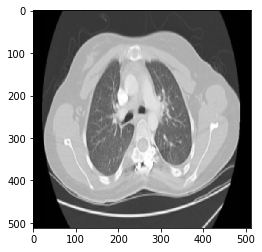

In [8]:
#Implementation Without K-Fold
img1 = 0
for batch in train_loader:
    img = batch
plt.imshow(img[0][0].view(512, 512, 3))

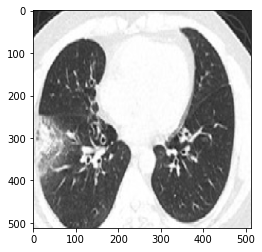

In [9]:
#Implementation Without K-Fold
img2 = 0
for batch in val_loader:
    img = batch
plt.imshow(img[0][0].view(512, 512, 3))

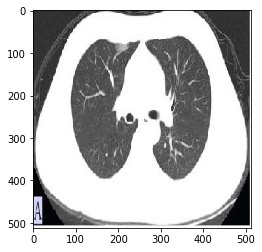

In [10]:
#Implementation Without K-Fold
img = 0
for batch in test_loader:
    img = batch
plt.imshow(img[0][0].view(512, 512, 3))

In [11]:
def validation(model, val_loader, criterion):
    '''
    Helper validation loss and accuracy function for use during model training
    
    Args:
        model: model object (ex: vgg16, resnet or custom model using nn.Module)
        val_loader: data loader for validation set
        criterion: loss function used for training
    
    Returns:
        test_loss: the loss during validation testing
        accuracy: the accuracy during validation testing
    '''
    
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(val_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        
        for index, i in enumerate(output):
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    return test_loss, accuracy

In [12]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler = None):
    '''
    Training loop function
    
    Args:
        model: model: model object (ex: vgg16, resnet or custom model using nn.Module)
        train_loader: data loader object with the training data
        val_loader: data loader object with the validation images
        optimizer: optimier used from torchvision.optim
        criterion: loss function used
        epochs: number of epochs that training loop runs
        scheduler: (optional) learning rate scheduler
        
    Returns:
        plot_train_loss: numpy array of training loss every epoch (length of epochs)
        plot_val_loss: numpy array of validation loss every epoch (length of epochs)
        plot_train_acc: numpy array of training accuracy every epoch (length of epochs)
        plot_val_acc: numpy array of validation accuracy every epoch (length of epochs)
    '''
    
    plot_train_loss = []
    plot_val_loss = []
    plot_train_acc = []
    plot_val_acc = []
    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        train_loss = 0
        for data in tqdm(train_loader):
            X, y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            for index, i in enumerate(output):
                if torch.argmax(i) == y[index]:
                    correct+=1
                total+=1
        
        #scheduler.step()
        model.eval()
                
        with torch.no_grad():
            val_loss, val_acc = validation(model, val_loader, criterion)
                    
        train_acc = correct/total
        
        print("Training Loss:", train_loss)
        plot_train_loss.append(train_loss)
        
        print("Training Accuracy:", train_acc)
        plot_train_acc.append(train_acc)
        
        print("Validation Loss:", val_loss)
        plot_val_loss.append(val_loss)
        
        print("Validation Accuracy:", val_acc)
        plot_val_acc.append(val_acc)
        
        model.train()
    
    plot_train_loss = np.array(plot_train_loss) 
    plot_val_loss = np.array(plot_val_loss)
    plot_train_acc = np.array(plot_train_acc)
    plot_val_acc = np.array(plot_val_acc)
    
    return plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc
        

In [13]:
def load_model_checkpoint(filepath):
    '''
    Helper function to load saved models in local directory
    
    Args:
        filepath: directory for model file
    
    Returns:
        model: the saved model object
    '''
    
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    return model

In [14]:
class CNN_COVIDCT(nn.Module):
    '''
    Custom COVID CT classifier using. 3 convolutional layers and 3 linear layers.
    
    Input:
        X: Batch of training images
        
    Output:
        Class probabilities for COVID positive and negative
    '''
    
    def __init__(self):
        super(CNN_COVIDCT, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)))
        
        self.linear = nn.Sequential(
            nn.Linear(64*60*60, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2),
            nn.Sigmoid())
          
    def forward(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.linear(X)
        
        return X

In [15]:
PRETRAINED = False

if PRETRAINED:
    MODEL_PATH = 'vgg19.pth'
    model = load_model_checkpoint(MODEL_PATH)

else:
    
    TO_SAVE = False
    model_name = 'custom'
    
    if model_name == 'vgg16':
        #####################################################################
        #VGG16: 30-35 epochs, Training Accuracy: 95%, Validation Accuracy: 93%
        #####################################################################
        assert(ORIG_RES == False)
        
        model = torchvision.models.vgg16(pretrained = True).to(device)
        
        for param in model.parameters():
            param.requires_grad = False

        layers_vgg16 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('activation1', nn.ReLU()),
            ('dropout1', nn.Dropout()),
            ('fc2', nn.Linear(512, 256)),
            ('activation2', nn.ReLU()),
            ('dropout2', nn.Dropout()),
            ('fc3', nn.Linear(256, 128)),
            ('activation3', nn.ReLU()),
            ('dropout3', nn.Dropout()),
            ('fc4', nn.Linear(128, 2)),
            ('out', nn.Sigmoid())

        ])).to(device)

        model.classifier = layers_vgg16
    
    elif model_name == 'resnet34':
        
        ######################################################################################
        #ResNet-34 model: Training Accuracy: ~50%, Validation Accuracy: ~50% (both oscillating)
        ######################################################################################
        assert(ORIG_RES == False)
        
        model = torchvision.models.resnet34(pretrained = True).to(device)
        for param in model.parameters():
            param.requires_grad = False

        layers_resnet = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 400)),
            ('activation1', nn.ReLU()),
            ('dropout1', nn.Dropout()),
            ('fc2', nn.Linear(400, 256)),
            ('activation2', nn.ReLU()),
            ('dropout2', nn.Dropout()),
            ('fc3', nn.Linear(256, 128)),
            ('activation3', nn.ReLU()),
            ('dropout3', nn.Dropout()),
            ('fc4', nn.Linear(128, 2)),
            ('out', nn.Sigmoid())

        ])).to(device)

        model.avgpool = nn.AdaptiveAvgPool2d(output_size = (7, 7))
        model.fc = layers_resnet
    
    elif model_name == 'vgg19':
        
        ##########################################################
        #VGG19: Training Accuracy: 94%, Validation Accuracy: ~91%
        ##########################################################
        assert(ORIG_RES == False)
        
        model = torchvision.models.vgg19(pretrained = True).to(device)

        for param in model.parameters():
            param.requires_grad = False

        layers_vgg19 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('activation1', nn.ReLU()),
            ('dropout1', nn.Dropout()),
            ('fc2', nn.Linear(512, 256)),
            ('activation2', nn.ReLU()),
            ('dropout2', nn.Dropout()),
            ('fc3', nn.Linear(256, 128)),
            ('activation3', nn.ReLU()),
            ('dropout3', nn.Dropout()),
            ('fc4', nn.Linear(128, 2)),
            ('out', nn.Sigmoid())

        ])).to(device)

        model.classifier = layers_vgg19

    elif model_name == 'custom':
        #assert(ORIG_RES == True)
        model = CNN_COVIDCT().to(device)
    
    
    epochs = 30

    optimizer = optim.Adam(model.parameters())
    #scheduler = ExponentialLR(optimizer, 0.9)
    criterion = nn.CrossEntropyLoss()

    plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc = train(model, train_loader, 
                                                                         val_loader, optimizer, criterion, epochs)
    if TO_SAVE:
        model_dir = None ####Change if want to save####
        checkpoints = {
            'model' : model,
            'input_size' : (224, 224, 3),
            'output_size' : 2,
            'state_dict' : model.state_dict()
        }
        
        assert(model_dir is not None)

        torch.save(checkpoints, model_dir)

  0%|          | 0/19 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 124.00 MiB (GPU 0; 4.00 GiB total capacity; 2.84 GiB already allocated; 107.80 MiB free; 2.86 GiB reserved in total by PyTorch)

In [15]:
class VGG19_CAM(nn.Module):
    '''
    Wrapper class for VGG19 to prepare activation hooks for class activation mapping.
    
    '''
    
    def __init__(self):
        super(VGG19_CAM, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = model.to(device)
        
        for param in self.vgg.parameters():
            param.requires_grad = True
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [16]:
def plot_train_val(num_epochs, fig_size):
    '''
    Plots training and validation loss and accuracy using pyplot.
    
    Args:
        num_epochs: number of epochs that model is trained for
        fig_size: size of output graph
    
    Returns: void
    '''
    
    plot_epochs = np.array([i for i in range(1, num_epochs+1)])
    fig, axs = plt.subplots(2, 2)
    
    axs[0, 0].plot(plot_epochs, plot_train_loss)
    axs[0, 0].set_title("Training Loss")
    
    axs[1, 0].plot(plot_epochs, plot_val_loss)
    axs[1, 0].set_title("Validation Loss")
    
    axs[0, 1].plot(plot_epochs, plot_train_acc)
    axs[0, 1].set_title("Training Accuracy")
    
    axs[1, 1].plot(plot_epochs, plot_val_acc)
    axs[1, 1].set_title("Validation Accuracy")
    
    fig.set_figheight(fig_size[0])
    fig.set_figwidth(fig_size[1])
    
#plot_train_val(epochs, (10, 10))

In [17]:
def test(model, test_loader, criterion):
    '''
    Model testing 
    
    Args:
        model: model used during training and validation
        test_loader: data loader object containing testing data
        criterion: loss function used
    
    Returns:
        test_loss: calculated loss during testing
        accuracy: calculated accuracy during testing
        y_proba: predicted class probabilities
        y_truth: ground truth of testing data
    '''
    
    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])
    
    return test_loss, accuracy, y_proba_out, y_truth_out

In [18]:
loss, acc, y_proba, y_truth = test(model, test_loader, criterion = nn.CrossEntropyLoss())

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


In [25]:
acc

0.9324324324324325

In [19]:
#torch.squeeze(torch.Tensor([1]))
np.squeeze(np.array(0))

array(0)

In [22]:
def display_FP_FN(model, test_loader, criterion, display = 'fp'):
    '''
    Displaying false positive or false negative images.
    
    Args:
        model: model used during training, testing and validation
        test_loader: data loader object for testing set
        criterion: loss function used
        display: either 'fp' for displaying false positives or 'fn' for false negatives
    
    Returns: void
    '''
    
    fp = []
    fn = []
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        for index, i in enumerate(output):
            if torch.argmax(i.to(device)) == torch.Tensor([1]) and y[index].to(device) == torch.Tensor([0]):
                fp.append(X[index])
            elif torch.argmax(i.to(device)) == torch.Tensor([0]) and y[index].to(device) == torch.Tensor([1]):
                fn.append(X[index])
    
    fig = plt.figure()
    
    if display == 'fp':
        n_img = len(fp)
        cols = int(math.sqrt(n_img))
        for idx, img in enumerate(fp):
            a = fig.add_subplot(cols, np.ceil(n_img/float(cols)), idx + 1)
            plt.imshow(img.view(224, 224, 3).cpu())
            plt.axis('off')
    
            
    elif display == 'fn':
        n_img = len(fn)
        cols = int(math.sqrt(n_img))
        for idx, img in enumerate(fn):
            a = fig.add_subplot(cols, np.ceil(n_img/float(cols)), idx + 1)
            plt.imshow(img.view(224, 224, 3).cpu())
            plt.axis('off')
    

100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


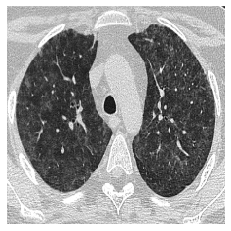

In [23]:
display_FP_FN(model, test_loader, criterion = nn.CrossEntropyLoss(), display = 'fp')

array([[32,  4],
       [ 1, 37]], dtype=int64)

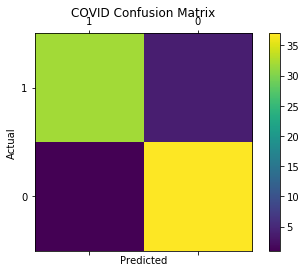

In [24]:
def get_confusion_matrix(y_truth, y_proba, labels):
    '''
    Displays confusion matrix given output and ground truth data.
    
    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        labels: a list of labels for each cell of confusion matrix
    
    Returns:
        cm: returns a numpy array representing the confusion matrix
        
    '''
    
    y_in = np.array([round(i) for i in y_proba])
    cm = confusion_matrix(y_truth, y_in, labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('COVID Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return cm

get_confusion_matrix(y_truth, y_proba, labels = [1, 0])

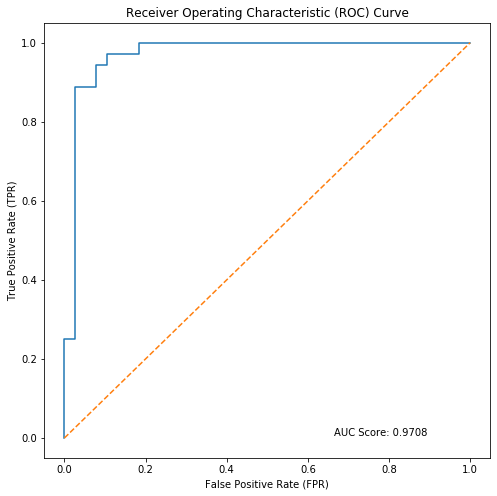

In [26]:
def plot_ROCAUC_curve(y_truth, y_proba, fig_size):
    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.
    
    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure
    
    Returns: void
    '''
    
    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))

In [27]:
def showCAM(model, dataloader):
    '''
    Displays class activation mapping for the final convolutional layer (GradCAM implementation from 
    https://arxiv.org/pdf/1610.02391.pdf and https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82)
    
    Args:
        model: model used during testing
        dataloader: dataloader object for test set
        
    Returns: void
    '''
    
    model.eval()
    img, _ = next(iter(dataloader))
    pred = model(img)
    idx = torch.argmax(pred)
    
    pred[:, 1].backward()

    gradients = model.get_activations_gradient()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    activations = model.get_activations(img).detach()

    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()

    heatmap = np.maximum(heatmap, 0)

    heatmap /= torch.max(heatmap)
    
    npmap = heatmap.numpy()
    heat_mp = cv2.resize(npmap, (224, 224))
    heat_map = np.uint8(255*heat_mp)
    
    colored_map = cv2.cvtColor(heat_map, cv2.COLOR_GRAY2RGB)
    final_heatmap = cv2.applyColorMap(colored_map, cv2.COLORMAP_JET)
    
    #Alpha blending
    superimposed_img = cv2.addWeighted(img.view(224, 224, 3).numpy(), 0.5, final_heatmap, 0.5, 0, dtype=cv2.CV_64F)

    
    f = plt.figure(figsize = (10, 10))
    f.add_subplot(1,3, 1)
    plt.imshow(img.view(224,224,3))
    f.add_subplot(1,3, 2)
    plt.imshow(final_heatmap)
    f.add_subplot(1,3, 3)
    plt.imshow(superimposed_img)
    plt.show(block=True)

In [28]:
cam_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


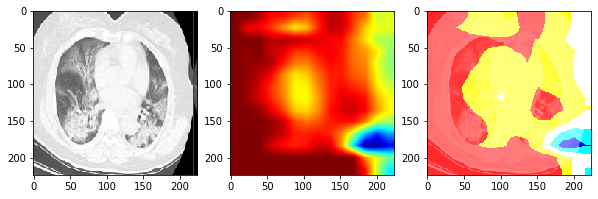

In [29]:
vgg = VGG19_CAM()
showCAM(vgg, cam_loader)